In [0]:
#Importing all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter

In [7]:
!pip install pyfolio
import pyfolio as pf

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [8]:
!pip install PyPortfolioOpt
#Installing the Portfolio Optimzation Library

In [0]:
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
from pypfopt.plotting import Plotting
from matplotlib.ticker import FuncFormatter

In [58]:
tickers = ['BSX','AES','BRK-B','SEE','QQQ','SPY']

thelen = len(tickers)

price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2012-01-01', end = '2020-06-06', data_source='yahoo')
    price_data.append(prices.assign(ticker=ticker)[['Adj Close']])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=['BSX','AES','BRK-B','SEE','QQQ','SPY']
df_stocks.head()


,BSX,AES,BRK-B,SEE,QQQ,SPY
Date,,,,,,
2012-01-03,5.36,9.460018,77.680000,15.016078,52.095646,108.037117
2012-01-04,5.31,9.389772,76.800003,15.128395,52.315380,108.206604
2012-01-05,5.34,9.616123,76.930000,15.024719,52.745693,108.494698
2012-01-06,5.30,9.545878,76.389999,15.154319,52.928810,108.215065
2012-01-09,5.35,9.733205,76.290001,15.137038,52.754841,108.477776
2012-01-10,5.53,9.912727,77.419998,15.102478,53.139385,109.418312
2012-01-11,5.54,9.881506,78.000000,15.214793,53.249256,109.477623
2012-01-12,5.56,9.795647,78.500000,15.577669,53.459831,109.740280
2012-01-13,5.52,9.873700,77.769997,15.534472,53.267567,109.172577


In [57]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df,columns=['BSX','AES','BRK-B','SEE','QQQ','SPY'])
print(nullin_df.isnull().sum())

BSX      0
AES      0
BRK-B    0
SEE      0
QQQ      0
SPY      0
dtype: int64


In [68]:
#Annluaized Return
mu = expected_returns.mean_historical_return(df_stocks) 
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

Expected annual return: 14.1%
Annual volatility: 16.2%
Sharpe Ratio: -0.49


(0.14098790020974616, 0.16232927730593885, -0.48673967568611337)

In [72]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(-1,1)) ##weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() ##May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)


{'BSX': 0.49791, 'AES': -0.1545, 'BRK-B': 0.14581, 'SEE': 0.05594, 'QQQ': 1.0, 'SPY': -0.54516}


In [73]:
ef.portfolio_performance(verbose=True, risk_free_rate = 0.22)
# 2year risk free rate - US Treasury Yield 

Expected annual return: 27.2%
Annual volatility: 22.6%
Sharpe Ratio: 0.23


(0.2717241579240359, 0.22620522703255694, 0.22866031259565653)

In [77]:
#Min Volatility Portfolio
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(-1,1)) ##weight bounds in negative allows shorting of stocks
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)

{'BSX': -0.02036, 'AES': -0.01334, 'BRK-B': 0.15925, 'SEE': 0.02001, 'QQQ': -0.14555, 'SPY': 1.0}


In [79]:
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.22)

Expected annual return: 13.0%
Annual volatility: 16.1%
Sharpe Ratio: -0.56


(0.13003794309960648, 0.16105434843723274, -0.5585819803893974)

In [0]:
from pypfopt.cla import CLA
from pypfopt.plotting import Plotting
from pypfopt import discrete_allocation

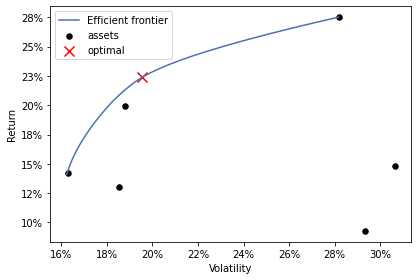

In [95]:
cl_obj = CLA(mu, Sigma)
ax = Plotting.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [99]:
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio() 
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))
print()
#Max Sharpe Ratio Portfolio Allocation $10000
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio() 
print(allocation_shp)
print("Leftover Fund value in$ after building Max Sharpe ratio portfolio: ${:.2f}".format(rem_f))

#allocation using integer programming via PyPortfolioOpt User Guide
#Alex Putkov code used for guidance and reference in applying integer programming

{'BRK-B': 6.0, 'SEE': 4.0, 'SPY': 27.0, 'BSX': -9.0, 'AES': -16.0, 'QQQ': -10.0}
Leftover Fund value in$ after building minimum volatility portfolio is $58.17

{'BSX': 75.0, 'BRK-B': 4.0, 'SEE': 8.0, 'QQQ': 25.0, 'AES': -47.0, 'SPY': -7.0}
Leftover Fund value in$ after building Max Sharpe ratio portfolio: $104.34
